In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import random
import torchvision

import torch
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [49]:
images_path = '../../data/' # Ruta de las imagenes
classes = os.listdir(images_path) # Carpetas con cada label.
print(f'Clases : {classes}')

Clases : ['paper', 'rock', 'scissors']


In [50]:
images,label = [],[] # Genero 2 listas con la ruta relativa de la imagen incluida esta, y otra con los labeles,
for ind,clase in enumerate(classes):
    direccion = os.listdir(f'{images_path}{clase}')
    images += [f'{images_path}{clase}/{img}' for img in direccion]
    label += [ind]*len(direccion)
print(images)
print(label)

['../../data/paper/04l5I8TqdzF9WDMJ.png', '../../data/paper/0a3UtNzl5Ll3sq8K.png', '../../data/paper/0cb6cVL8pkfi4wF6.png', '../../data/paper/0eqArS2GgsBeqgSn.png', '../../data/paper/0Og76sl5CJhbxWWx.png', '../../data/paper/0RA9rcrv8iVvuDDU.png', '../../data/paper/0t08v9bAaA0mXGCQ.png', '../../data/paper/0Uomd0HvOB33m47I.png', '../../data/paper/0vugygEjxQJPr9yz.png', '../../data/paper/0zKU6wEhT2cDe9j0.png', '../../data/paper/14K62H4KG1hg5qiJ.png', '../../data/paper/1Dfw5FRlS4h60JPX.png', '../../data/paper/1fKclJk4eBWOQSR1.png', '../../data/paper/1Frbe8cdOdkciOBg.png', '../../data/paper/1jHtb93pI8f6pfKo.png', '../../data/paper/1oKnUgV2CdCaQUUX.png', '../../data/paper/1Tt9U9SzrOm98Xtw.png', '../../data/paper/1uoW7QcH2qAgCTxv.png', '../../data/paper/1yeoLbmp4alVOtFv.png', '../../data/paper/1yKjzquSvl9ShK7K.png', '../../data/paper/27XFtQjjXQ8AP8Tl.png', '../../data/paper/2DQbLQfHlfrcATqi.png', '../../data/paper/2F8Ng7620ANA7tEK.png', '../../data/paper/2IOsxsG8AaxntdJM.png', '../../data/pap

### Labels: 0  = Papel,  1 = Rock , 2 = Scissors

In [51]:
clases = {
    0: 'Papel',
    1:'Rock',
    2:'Scissors'
}

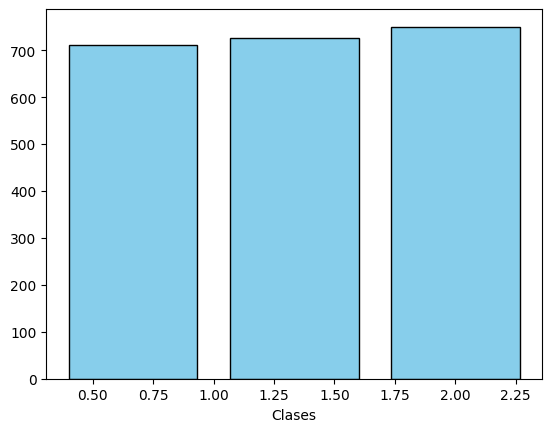

In [52]:
plt.hist(label,bins=3,align='right', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Clases')
plt.show()

## Se puede observar una distribucion semejange entre las clases

## Voy a mostrar algunas imagenes

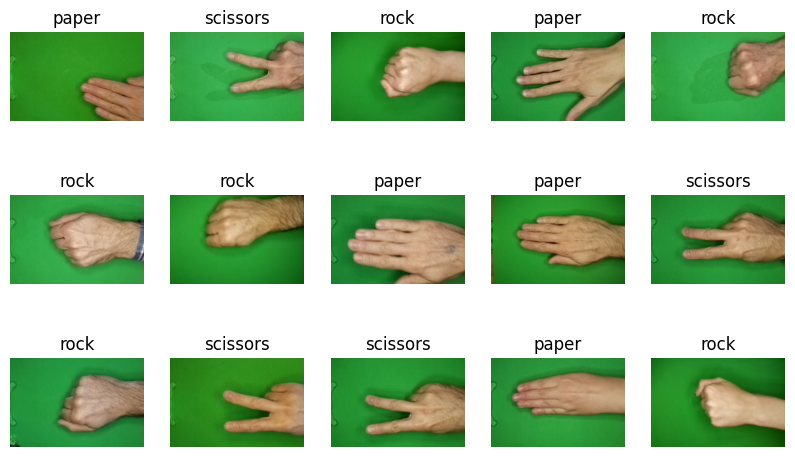

In [53]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(images)-1) # Genero un indice random para la lista de iamgenes
    img = io.imread(images[ix]) # Leo con imread a la imagen segun indice
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[label[ix]]) # Veo las clases con el indice
plt.show()

### Procedo a separar los datos en conjunto de entrenamiento y testeo


In [54]:
train_images, test_images, train_labels, test_labels = train_test_split(images, label, test_size=0.2, random_state=42)

A menudo Pytorch funciona mejor en tarjeta grafica, por esto genero una variable device para poder usarla en el caso de tenerse la posibilidad

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ahora generare el conjunto de datos apropiado que pytorch necesita para el modelo,
para estoy primero voy a generar la clase Dataset que herada de Dataset de Pytorch, la cual tenedra como atributos el conjunto X y sus labels, ademas de un metodo(__getitem__) para tener los datos de forma apropiada

In [56]:
class Dataset(torch.utils.data.Dataset): # Genero la clase Dataset para las imagenes
  def __init__(self, X, y, trans, device):
    self.X = X # Conjunto de imagenes
    self.y = y # Clases
    self.trans = trans # Trasnformacion que pueda aplicarle
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix]) #Leo la imagen
    img = Image.fromarray(img)
    # aplicar transformaciones
    if self.trans: # Si incorpore una trasnformacion la aplico
      img = self.trans(img)
    return img, torch.tensor(self.y[ix]) #Retorno cfomo tensor, con la imagen normalizada y permutadando dfebido a los canales

Ahora voy a instanciar la clase Dataset, con mis datos, no sin antes definir un transformador para asegurarme que las imagenes tengan todas los tamaños adecuados

In [57]:
transform = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),

]) # Realizo una trasnformacion para escalar las imagenes a 224x224

In [58]:
# Diccionario dataset, que contiene un objeto dataset para train y test
dataset = {
    'train': Dataset(train_images, train_labels, transform, device),
    'test': Dataset(test_images, test_labels, transform, device),

}

Para realizar un entrenamiento mas optimo para a definir dataloaders para tener batch de 64 imagnees

In [59]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

print(f'Conjunto de entrenamiento:{len(dataset["train"])},Conjunto de testeo:{len(dataset["test"])}')

Conjunto de entrenamiento:1750,Conjunto de testeo:438


Ahora que esta todo las dimensiones para poder aceptarse por pytorc deberian ser (64,3,224,224) para cada batch

In [60]:
for imgs, labels in iter(dataloader['train']):
  print(imgs.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([22, 3, 224, 224])


## Todo esta en orden, es momento de pasar a definir la red neuronal

In [76]:
# Funcion que se encarga del entrenamiento
def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    accuaracy_train,acuaracy_test = [],[]
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        accuaracy_train.append(np.mean(train_acc))
        acuaracy_test.append(np.mean(val_acc))
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    return [accuaracy_train,acuaracy_test]

## Red neuronal creada por capas

In [75]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )
# Define la clase CNN
class CNN(torch.nn.Module):
    def __init__(self, n_channels=3, n_outputs=3):
        super().__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.fc = torch.nn.Linear(128*7*7, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [ ]:
model = CNN()
metrics  = fit(model, dataloader)

### Definición de la red neuronal a partir de la arquitectura de la red resnet, modificando la capa de salida para que tenga 3 clases.

In [61]:
#Importo el modelo resnet, el cual es un modelo preentrenado con 1000 salidas
resnet = torchvision.models.resnet18()

In [62]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añado una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 3)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True


## 1 Caso: parametro pretrained = False es decir, no voy a usar los pesos que ya tiene el modelo, solo su estructura.

In [77]:
model = Model(pretrained=False)
epochs = 8
metrics = fit(model, dataloader, epochs=8)

c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
val_loss 1.38015 val_acc 0.30552: 100%|██████████| 2/2 [00:21<00:00, 10.63s/it]


Epoch 1/8 loss 0.89036 val_loss 1.38015 acc 0.60004 val_acc 0.30552


val_loss 1.60393 val_acc 0.46094: 100%|██████████| 2/2 [00:20<00:00, 10.11s/it]


Epoch 2/8 loss 0.37515 val_loss 1.60393 acc 0.93760 val_acc 0.46094


val_loss 0.45972 val_acc 0.82810: 100%|██████████| 2/2 [00:19<00:00,  9.95s/it]


Epoch 3/8 loss 0.15538 val_loss 0.45972 acc 0.97885 val_acc 0.82810


val_loss 0.24934 val_acc 0.92443: 100%|██████████| 2/2 [00:20<00:00, 10.05s/it]


Epoch 4/8 loss 0.08979 val_loss 0.24934 acc 0.98549 val_acc 0.92443


val_loss 0.13256 val_acc 0.97259: 100%|██████████| 2/2 [00:35<00:00, 17.94s/it]


Epoch 5/8 loss 0.06394 val_loss 0.13256 acc 0.98772 val_acc 0.97259


val_loss 2.17169 val_acc 0.40556: 100%|██████████| 2/2 [00:26<00:00, 13.45s/it]


Epoch 6/8 loss 0.05714 val_loss 2.17169 acc 0.98940 val_acc 0.40556


val_loss 0.71746 val_acc 0.64333: 100%|██████████| 2/2 [00:22<00:00, 11.45s/it]


Epoch 7/8 loss 0.04582 val_loss 0.71746 acc 0.99112 val_acc 0.64333


val_loss 0.40268 val_acc 0.85045: 100%|██████████| 2/2 [00:21<00:00, 10.95s/it]

Epoch 8/8 loss 0.04129 val_loss 0.40268 acc 0.98940 val_acc 0.85045


## Se puede observar que la funcion de perdida obtuvo un valor bastante bajo primer epoch que fue 0.8

In [121]:
def plot_accuracy(epochs, metrics):
    plt.scatter(list(range(1,epochs+1)),metrics[0],label='Accuaricy Train')
    plt.scatter(list(range(1,epochs+1)),metrics[1],label='Accuaricy Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuaricy')
    plt.legend()
    plt.title("Rendimiento por cada iteración")
    plt.show()

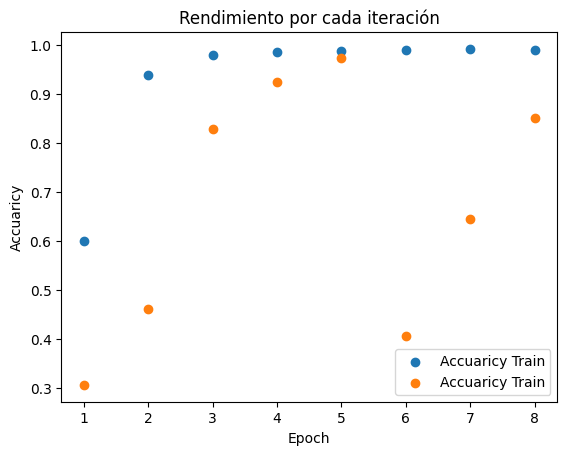

In [118]:
plot_accuracy(epochs, metrics)

## Se puede observar que en el epoch numero 5 se alcanza uno de los valores mas altos de accuaricy tanto para train como test, luego s ve que no aumenta tanto y ademas el accuaricy de test baja mucho, lo cual dice que el modelo empezo a sufrir overfiting

## Caso 2 : Usando el paramertro pretrained = True para usar los pesos que ya posee el modelo de resnet (entrenado con millones de imagenes.), Ademas usamos True el parametro freeze el cual me permite que se actualizen o no los pesos existentes.

In [119]:
model = Model(pretrained=True,freeze=True)
epochs = 8
metrics = fit(model, dataloader, epochs=8)

c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\bruno/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%
val_loss 0.62162 val_acc 0.76071: 100%|██████████| 2/2 [00:23<00:00, 11.97s/it]


Epoch 1/8 loss 0.76896 val_loss 0.62162 acc 0.70480 val_acc 0.76071


val_loss 0.29589 val_acc 0.94360: 100%|██████████| 2/2 [00:32<00:00, 16.39s/it]


Epoch 2/8 loss 0.37150 val_loss 0.29589 acc 0.94217 val_acc 0.94360


val_loss 0.19220 val_acc 0.97729: 100%|██████████| 2/2 [00:24<00:00, 12.19s/it]


Epoch 3/8 loss 0.25396 val_loss 0.19220 acc 0.97098 val_acc 0.97729


val_loss 0.16523 val_acc 0.97454: 100%|██████████| 2/2 [00:22<00:00, 11.05s/it]


Epoch 4/8 loss 0.21182 val_loss 0.16523 acc 0.97098 val_acc 0.97454


val_loss 0.15793 val_acc 0.97180: 100%|██████████| 2/2 [00:21<00:00, 10.65s/it]


Epoch 5/8 loss 0.17857 val_loss 0.15793 acc 0.97387 val_acc 0.97180


val_loss 0.12217 val_acc 0.98865: 100%|██████████| 2/2 [00:21<00:00, 10.75s/it]


Epoch 6/8 loss 0.15751 val_loss 0.12217 acc 0.97829 val_acc 0.98865


val_loss 0.11130 val_acc 0.98669: 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]


Epoch 7/8 loss 0.13596 val_loss 0.11130 acc 0.98158 val_acc 0.98669


val_loss 0.10034 val_acc 0.99060: 100%|██████████| 2/2 [00:20<00:00, 10.41s/it]

Epoch 8/8 loss 0.11579 val_loss 0.10034 acc 0.98717 val_acc 0.99060


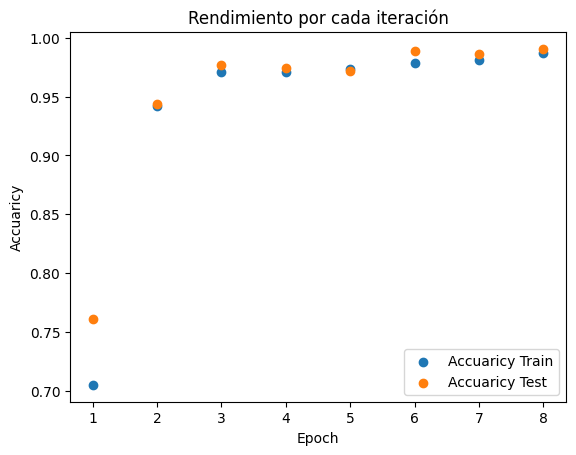

In [122]:
plot_accuracy(epochs, metrics)

## Se puede ver en este caso que a partir de 3 o 4 epoch ya se alcanza un valor de accuaricy bastante elebado, y no se observa overfiting, ademas que al usar los pesos y no actualizarlos el tiempo de entrenamiento fue de la mitad.